# 均值方差模型

投资组合是否能够产生具有吸引力的风险收益特征主要取决于大类资产之间的相关性。分散投资能够降低风险（个别风险），但经验丰富的投资者会选择承受个别风险，对于没有能力选择个别风险的投资者，分散投资是最好的选择。分散投资是为数不多的不用额外支付保险费或者对冲费就能降低风险的方法。如果投资目标是发大财，那投资组合还是集中一些好；如果是保值增值，那就应该选择分散投资。

具体可以参看：[均值方差模型](../方法论/主动投资组合管理/均值方差模型.ipynb)

## 两资产组合的风险收益特征

,Annual Return,Volatility,Sharpe Ratio(rf=0),Stock,Bond,Cash,Gold
Stock,0.073278,0.241582,0.303324,1.000000,-0.014142,0.010884,0.072357
Bond,0.040356,0.014729,2.739881,-0.014142,1.000000,0.149490,0.013026
Cash,0.032490,0.001726,18.824372,0.010884,0.149490,1.000000,0.034685
Gold,0.056331,0.157193,0.358355,0.072357,0.013026,0.034685,1.000000


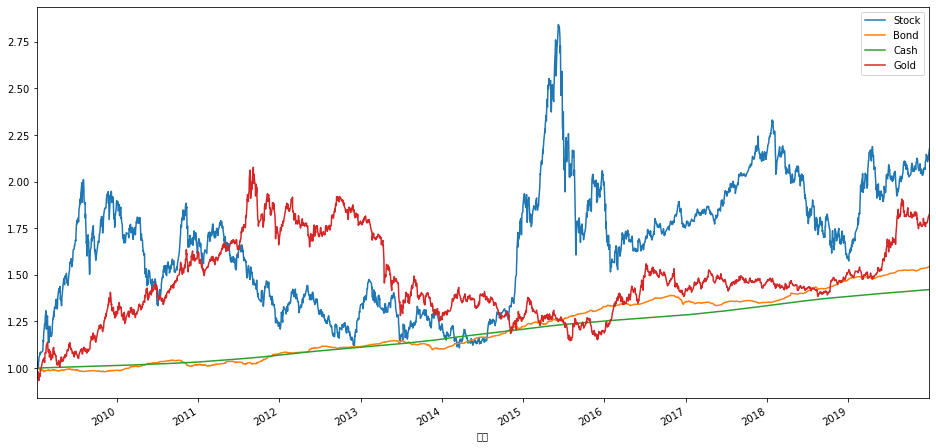

In [4]:
# 读取资产价格数据
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

AssetPrice = pd.read_csv("./csv/AssetPrice0.csv", index_col=0, header=0, parse_dates=True, infer_datetime_format=True, encoding="utf-8")
AssetPrice = AssetPrice.rename(columns={"000300.SH": "Stock", "H11001": "Bond", "H11025": "Cash", "AUCI.SHF": "Gold"})
# AssetPrice = AssetPrice.rename(columns={"000300.SH": "CN_Stock", "H11001": "Bond", "H11025": "Cash", "AUCI.SHF": "Gold", ".GSPC.NYSE": "US_Stock"})
# AssetPrice.pop("HSI.HK")
# AssetPrice = AssetPrice.rename(columns={"000300.SH": "CN_Stock", "H11001": "Bond", "H11025": "Cash", "AUCI.SHF": "Gold", ".GSPC.NYSE": "US_Stock", "HSI.HK": "HK_Stock"})
# AssetPrice = AssetPrice.rename(columns={"000300.SH": "CN_Big_Stock", "000905.SH": "CN_Mid_Stock", "000852.SH": "CN_Small_Stock", "H11006": "T_Bond", "H11007": "F_Bond", "H11008": "C_Bond", "H11025": "Cash", "AUCI.SHF": "Gold", ".GSPC.NYSE": "US_Stock", "HSI.HK": "HK_Stock"})
(AssetPrice / AssetPrice.iloc[0]).plot(figsize=(16, 8));

# 年化收益率
Return = (AssetPrice.iloc[-1] / AssetPrice.iloc[0]) ** (365 / (AssetPrice.index[-1] - AssetPrice.index[0]).days) - 1
# 协方差矩阵
Cov = AssetPrice.pct_change().cov() * 252
# 相关系数矩阵
Volatility = pd.Series(np.diag(Cov.values)**0.5, index=Cov.index)
Rho = pd.DataFrame((Cov.values / Volatility.values).T / Volatility.values, index=Cov.index, columns=Cov.columns)

# Formatters = [lambda x: '{0: .2f}%'.format(x*100)]*2 + [lambda x: '{0: .2f}'.format(x)]*7
Summary = pd.DataFrame({"Annual Return": Return, "Volatility": Volatility, "Sharpe Ratio(rf=0)": Return / Volatility})
display(Summary.merge(Rho, left_index=True, right_index=True))



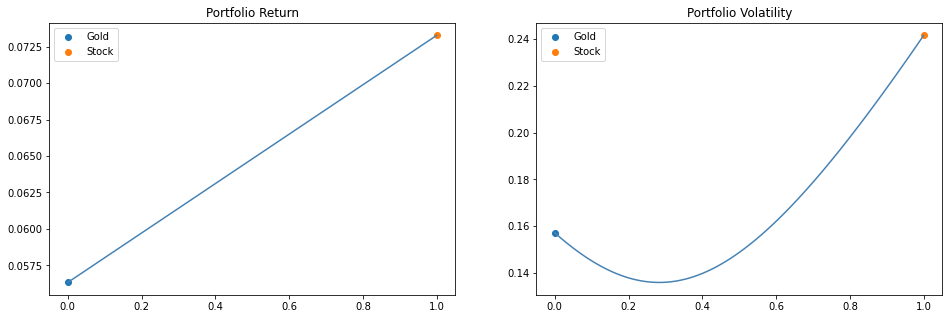

In [5]:
# 两个资产的投资组合的风险和收益特征
import matplotlib.pyplot as plt

a1, a2 = "Stock", "Gold"
# 资产 1 的权重
w = np.linspace(0, 1, 100)
r = w * Return[a1] + (1-w) * Return[a2]
sigma = (w**2 * Volatility[a1]**2 + (1-w)**2 * Volatility[a2]**2 + 2*w*(1-w)*Rho.loc[a1, a2]*Volatility[a1]*Volatility[a2]) ** 0.5

Fig, Axes = plt.subplots(1,2,figsize=(16, 5))
Axes[0].plot(w, r, color="steelblue", linewidth=1.5)
Axes[0].scatter(0, Return[a2], label=a2)
Axes[0].scatter(1, Return[a1], label=a1)
Axes[0].set_title("Portfolio Return")
Axes[0].legend(loc="best")
Axes[1].plot(w, sigma, color="steelblue", linewidth=1.5)
Axes[1].scatter(0, Volatility[a2], label=a2)
Axes[1].scatter(1, Volatility[a1], label=a1)
Axes[1].set_title("Portfolio Volatility")
Axes[1].legend(loc="best");

## 有效前沿

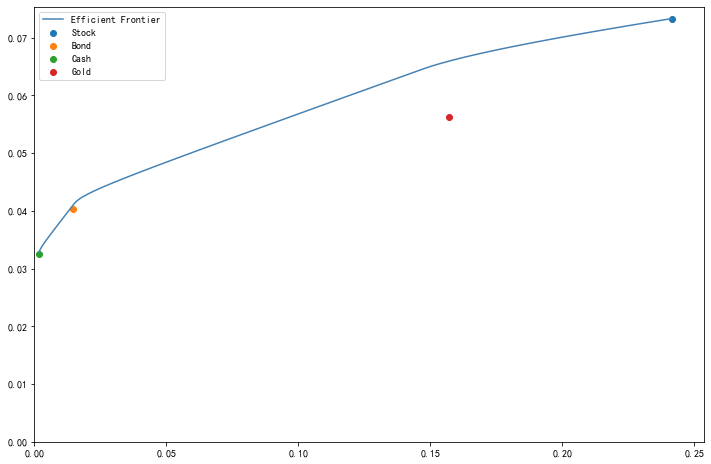

In [6]:
# 有效前沿
from QuantStudio.Tools import PortfolioModel

r, sigma = PortfolioModel.calcEfficientFrontier(Cov.values, Return.values, allow_short=False)

import matplotlib.pyplot as plt
Fig, Axes = plt.subplots(1, 1, figsize=(12, 8))
Axes.plot(sigma, r, label="Efficient Frontier", color="steelblue")
for i, iAsset in enumerate(Return.index):
    Axes.scatter(Cov.values[i, i]**0.5, Return.values[i], label=Return.index[i])
Axes.set_xlim(left=0)
Axes.set_ylim(bottom=0)
Axes.legend(loc="best");

# 基于风险的大类资产配置

基于风险程度，将所有的资产分成三类：
* 安全类（Safe Bucket）：目标就是安全第一，无法忍受任何损失或者风险。对于个人投资者，一般是其毕生储蓄，用于养老；对于机构投资者，主要是为了匹配负债或者应对监管要求的资产。
* 市场风险类（Market Risk Bucket）：这类风险是投资者可接受的，投资这类资产的目的是为了实现长期资本真实增值。市场风险类资产应该在不同的 beta 和 alpha 之间分散投资，业绩比较基准也要与资产的投资目标相匹配
* 风险资产类（Risky Bucket）：实际上这是一种投机型风险，这类资产在投资者的个人财富中比例较小，可能不到 20%，其需要投资者有相应的风险承担意愿和风险承担能力，其投资标的是集中的。风险类资产一般没有比较基准，表现应该使用绝对收益形式。

投资者可以在三类资产中进行资金转换。基于风险的资产配置方法帮助投资者整体的考量自己的所有财产，并针对每一类资产分别明确风险水平和投资技术（这种方法实际上是“心理账户”的认知偏差的延伸）。

## 风险预算模型

具体参看：[风险预算模型](../方法论/主动投资组合管理/风险预算模型.ipynb)

In [10]:
# 风险预算模型
from QuantStudio.Tools import PortfolioModel

w = PortfolioModel.calcRiskBudgetPortfolio(Cov.values, b=None)# 风险平价
# w = PortfolioModel.calcRiskBudgetPortfolio(Cov.values, b=np.array([0.9, 0.05, 0.04, 0.01]))# 风险预算

w = pd.Series(w, index=Cov.index)
print(w)

Stock    0.006652
Bond     0.105354
Cash     0.878016
Gold     0.009978
dtype: float64


## 最大分散化模型

In [11]:
# 最大分散化模型
from QuantStudio.Tools import PortfolioModel

w = PortfolioModel.calcMaxDiversificationPortfolio(Cov.values)

w = pd.Series(w, index=Cov.index)
print(w)

Stock    0.007083
Bond     0.108639
Cash     0.873936
Gold     0.010342
dtype: float64


# 耶鲁模型

耶鲁大学基金会的首席投资官 Swensen 于 2000 年著的《Pioneering Portfolio Management: An Unconventional Approach to Institutional Investment》中提出了耶鲁模型，耶鲁模型将资产等分为 5-6 份，每份投资于一类大类资产，大类资产之间的相关性很低。同时，该模型认为由于获得流动性是以牺牲收益为代价的，所以不应该配置流动性资产，耶鲁大学基金只配置于非流动性资产，比如私募股权。

# 参考文献

[<a id="cit-Qutke:2018" href="#call-Qutke:2018">况客研究:2018</a>] 况客研究, FOF投资的量化分析, 中国金融出版社, 2018.

[<a id="cit-Lustig:2016" href="#call-Lustig:2016">Lustig:2016</a>] Yoram Lustig 著, 孙静, 郑志勇, 李韵 译, 资产配置投资实践, 电子工业出版社, 2016.